# Visualizing Multiple Optimizers

### Useful URLS:
* [Sebastian Ruder : Refresher on Optimizers](https://ruder.io/optimizing-gradient-descent/)
* [Sebastian Ruder : Highlights of 2017 Optimizations](https://ruder.io/deep-learning-optimization-2017/index.html#decouplingweightdecay)
* [SGDR Explained for Beginners](https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 6]
import os

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

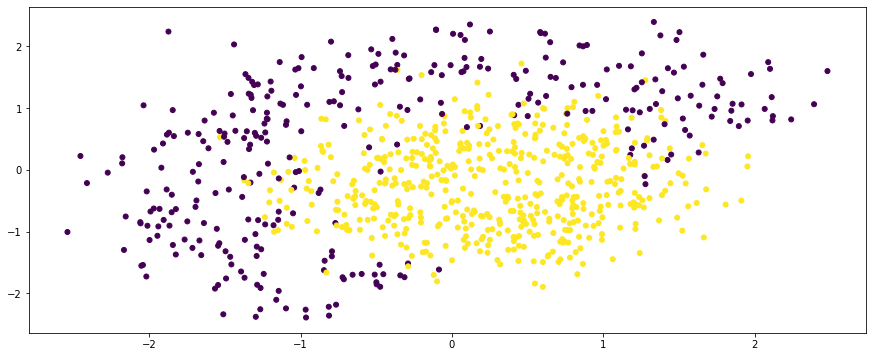

In [2]:
with open('data/train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('data/target.npy', 'rb') as fin:
    y = np.load(fin)
fig,ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, s=25)
plt.show()

# Task

## Features

As you can notice the data above isn't linearly separable. Since that we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](assets/kernel.png)

In [3]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    
    # TODO:<your code here>
    X_expanded[:,[0,1]] = X
    X_expanded[:,[2,3]] = np.square(X)
    X_expanded[:,4] = np.multiply(X[:,0],X[:,1])
    X_expanded[:,5] = 1
    
    return X_expanded

In [4]:
X_expanded = expand(X)

In [5]:
X_expanded.shape

(826, 6)

Here are some tests for your implementation of `expand` function.

## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [6]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    wX = np.exp(-1 * np.dot(w,np.transpose(X)))
    return 1/(1 + wX)

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [7]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    # TODO:<your code here>
    cross_entropy =  -1 * (y * np.log(probability(X,w)) + (1-y)* np.log(1 - probability(X,w)))
    return np.sum(cross_entropy)/cross_entropy.shape[0]

In [8]:
X_expanded.shape,y.shape

((826, 6), (826,))

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

In [9]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    p = probability(X,w)
    p_y = p-y
    grad = np.matmul(np.transpose(X),p_y)
    grad_avg = grad/X.shape[0]
    return grad_avg

Here's an auxiliary function that visualizes the predictions:

In [10]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
count = 0

def visualize(X, y, w, history,folder_name=None):
    """draws classifier prediction with matplotlib magic"""
    global count
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z,  cmap='RdGy')
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    if not os.path.exists(f"imgs/{folder_name}"):
        os.makedirs(f"imgs/{folder_name}")
    plt.savefig(f"imgs/{folder_name}/{folder_name}+{count}.png")
    count += 1
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

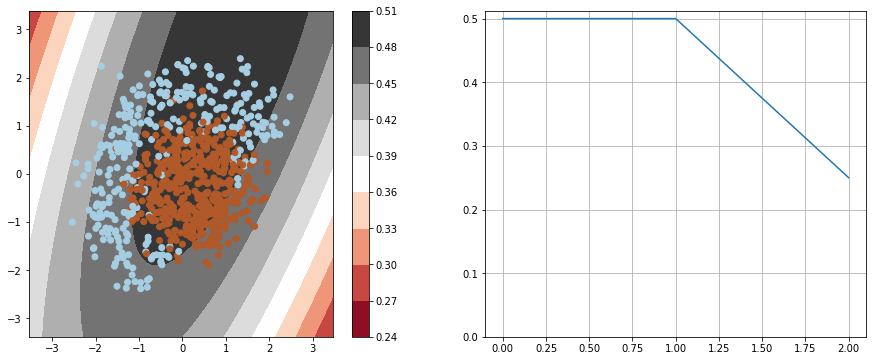

In [11]:
visualize(X, y, [0.01,0.02,-0.04,-0.01,0.03,-0.02], [0.5, 0.5, 0.25], "testing")

## Training
In this section we'll use the functions you wrote to train our classifier using stochastic gradient descent.

You can try change hyperparameters like batch size, learning rate and so on to find the best one, but use our hyperparameters when fill answers.

## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



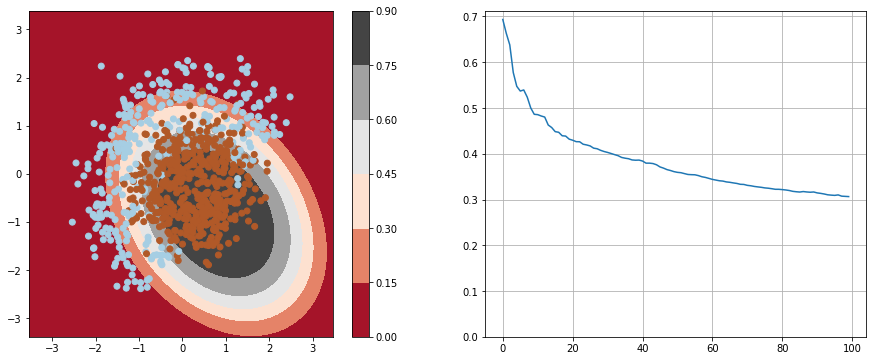

<Figure size 1080x432 with 0 Axes>

In [14]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss,"mini_batch_sgd")

    # Keep in mind that compute_grad already does averaging over batch for you!
    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    w = w - eta * batch_grad

visualize(X, y, w, loss,"mini_batch_sgd")
plt.clf()

## Optimizers and their Chronology
![](assets/optimizers_chronology.png)

## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](assets/sgd.png)


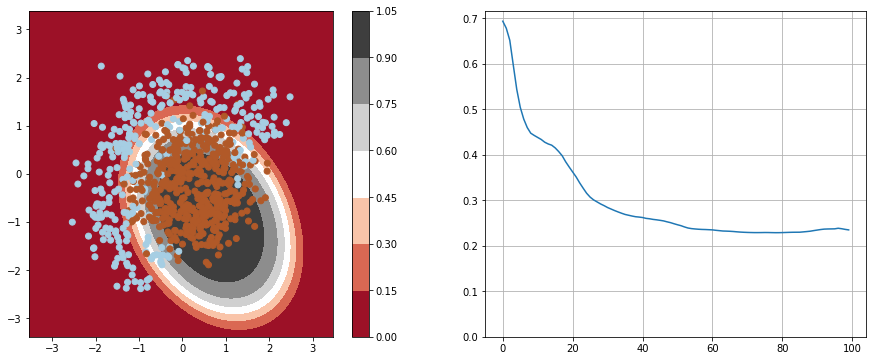

<Figure size 1080x432 with 0 Axes>

In [27]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "sgd_with_momentum")

    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    nu = alpha * nu + eta * batch_grad
    w = w - nu

visualize(X, y, w, loss, "sgd_with_momentum")
plt.clf()

## SGD with Nesterov Momentum

Similar to SGD with momentum but

<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t + \alpha \nu_{t-1}) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>

<b> This is similar to and valid for all of the optimizers </b>

$$ \nu_t = \alpha \nu_{t-1} - \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t + \alpha \nu_{t-1}) $$
$$ w_t = w_{t-1} + \nu_t$$

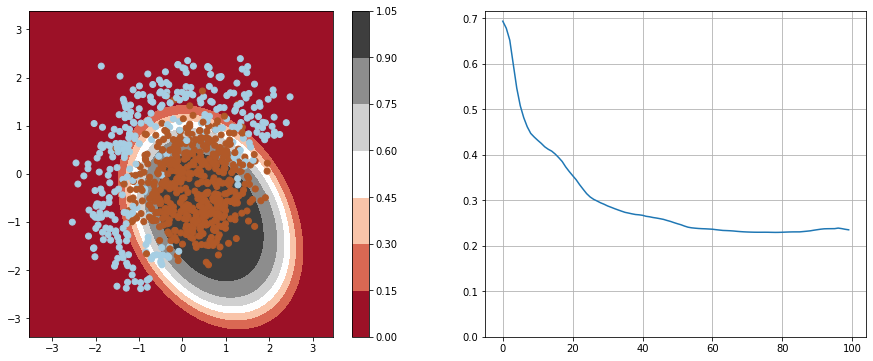

<Figure size 1080x432 with 0 Axes>

In [16]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "sgd_with_nesterov")

    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w+ alpha* nu)
    nu = alpha * nu - eta * batch_grad
    w = w + nu

visualize(X, y, w, loss, "sgd_with_nesterov")
plt.clf()

## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

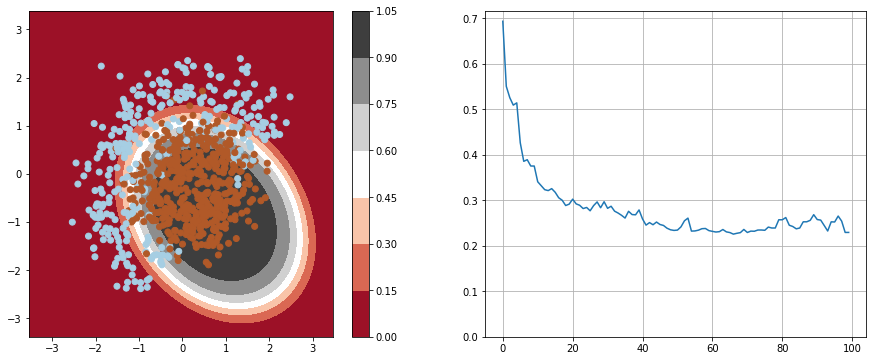

<Figure size 1080x432 with 0 Axes>

In [17]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = None # we start with None so that you can update this value correctly on the first iteration
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "rmsprop")

    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    if g2 is None:
        g2 = (1-alpha) * np.square(batch_grad)
    else:
        g2 = alpha * g2 + (1-alpha) * np.square(batch_grad)
        
    w = w - (eta/np.sqrt(g2 + eps)) * batch_grad
    
    

visualize(X, y, w, loss, "rmsprop")
plt.clf()

## Adam Lr = 0.001

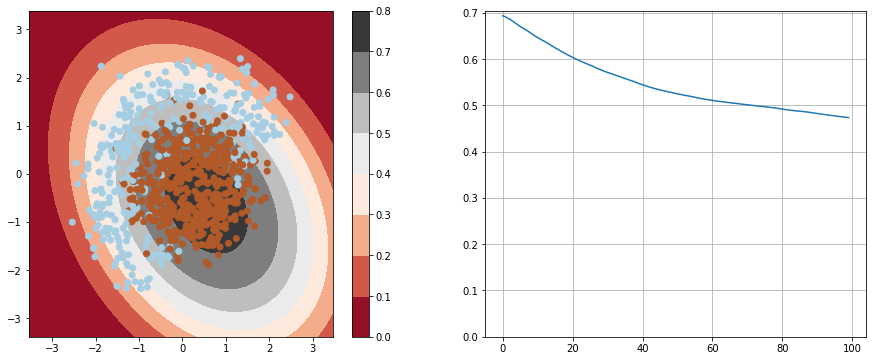

<Figure size 1080x432 with 0 Axes>

In [19]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.001 # learning rate
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size,)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss,  "adam_lr_0.001")

    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    
    
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    
    #bias correction
    #mt = mt / (1 - np.power(beta_1,i+1))
    #nu = nu / (1 - np.power(beta_2,i+1))
    
    w = w - (((eta)/(np.sqrt(nu) + eps)) * mt)
     

visualize(X, y, w, loss, "adam_lr_0.001")
plt.clf()

## Adam with Lr = 0.0001

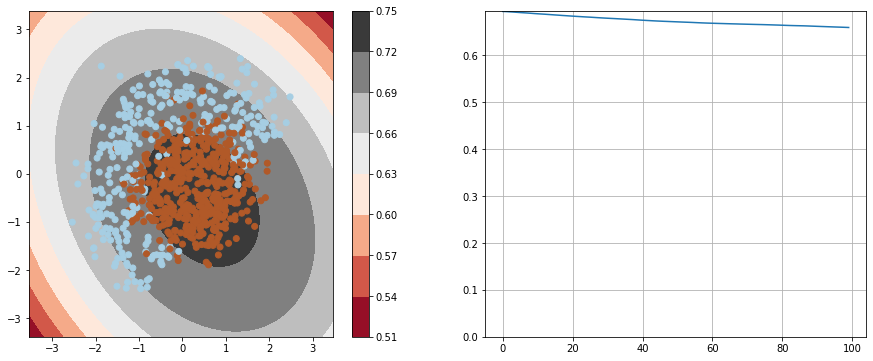

<Figure size 1080x432 with 0 Axes>

In [20]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.0001 # learning rate
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "adam_lr_0.0001")

    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    
    
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    
    #bias correction
    #mt = mt / (1 - np.power(beta_1,i+1))
    #nu = nu / (1 - np.power(beta_2,i+1))
    
    w = w - (((eta)/(np.sqrt(nu) + eps)) * mt)
     

visualize(X, y, w, loss, "adam_lr_0.0001")
plt.clf()

## Adam with Monotonic Decreasing Learning Rate


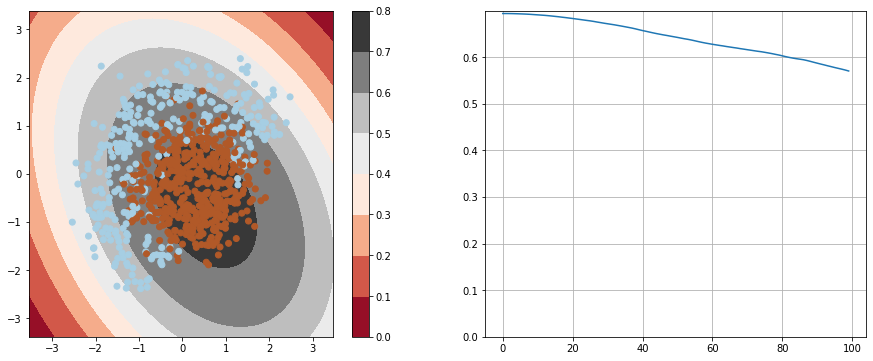

<Figure size 1080x432 with 0 Axes>

In [26]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = np.linspace(0.00001,0.01,1000)
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss,"adam_mono_dec")

    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    
    
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    
    #bias correction
    #mt = mt / (1 - np.power(beta_1,i+1))
    #nu = nu / (1 - np.power(beta_2,i+1))
    
    w = w - (((eta[i])/(np.sqrt(nu) + eps)) * mt)
     

visualize(X, y, w, loss, "adam_mono_dec")
plt.clf()

## Adam with Randomized LR within Bounds

Implementing LR within Bounds of 0.01 and 0.00001 but generally the max_lr and min_lr bounds are determined by LR Test.

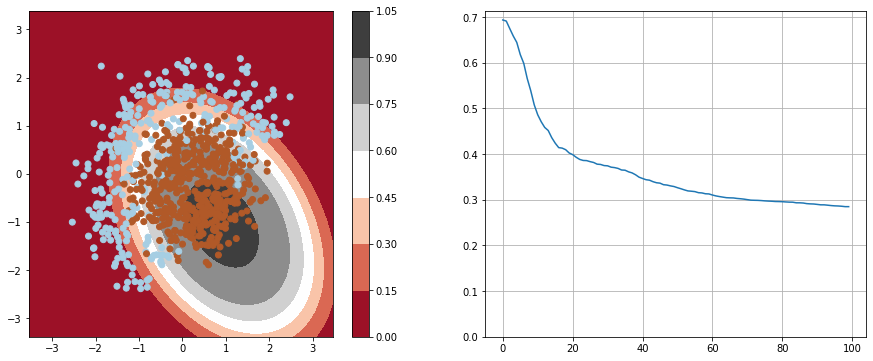

<Figure size 1080x432 with 0 Axes>

In [23]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = np.linspace(0.00001,0.01,1000)
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "adam_with_random_lr")

    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    
    
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    
    #bias correction
    #mt = mt / (1 - np.power(beta_1,i+1))
    #nu = nu / (1 - np.power(beta_2,i+1))
    
    w = w - (((np.random.choice(eta))/(np.sqrt(nu) + eps)) * mt)
     

visualize(X, y, w, loss, "adam_with_random_lr")
plt.clf()

## AMS Grad without Time Step
"A Lot of Noise for Nothing" ~ [Fast.ai](https://www.fast.ai/2018/07/02/adam-weight-decay/#amsgrad)

According to it's reception it didn't show any metric improvement better than the original Adam.


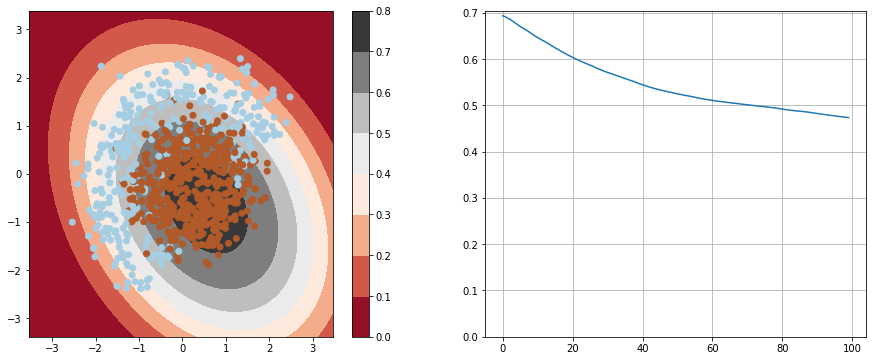

<Figure size 1080x432 with 0 Axes>

In [24]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.001 # learning rate
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "ams_without_timestep")

    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w )
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu_calc = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    if nu_calc.sum() > nu.sum():
        nu = nu_calc
    w = w - ((eta)/(np.sqrt(nu) + eps)) * mt
     

visualize(X, y, w, loss, "ams_without_timestep")
plt.clf()

## Ams Grad with Time Step

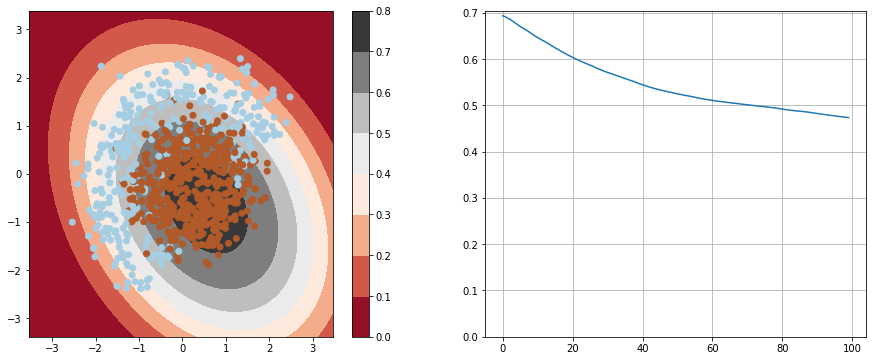

<Figure size 1080x432 with 0 Axes>

In [25]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.001 # learning rate
beta_1 = 0.9 
beta_2 = 0.999
eps = 1e-7
mt = np.zeros_like(w)
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss, "ams_with_timestep")

    # TODO:<your code here>
    batch_grad = compute_grad(X_expanded[ind],y[ind],w)
    mt = beta_1 * mt + (1-beta_1) * batch_grad
    nu_calc = beta_2 * nu + (1-beta_2) * np.square(batch_grad)
    if nu_calc.sum() > nu.sum():
        nu = nu_calc
    w = w - ((eta)/(np.sqrt(nu) + eps)) * mt
     

visualize(X, y, w, loss, "ams_with_timestep")
plt.clf()